# Auto ml for financial and textual data

## Auto ml for financial data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn import preprocessing

random_state = 42

In [2]:
financial_dataset = pd.read_csv('bankrupt_companies_with_17variables_5years_split_version4_complete.csv')
print(financial_dataset.shape)
financial_dataset.head(10)

(36070, 22)


,cik,ticker,label,subset,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,1476045,CLDT,False,train,Dec 2016,176.5,48.6,58.0,106.7,119.3,...,31.5,-45.7,295.9,1303.0,41.6,38.5,390.0,621.4,59.9,4.4
1,1476045,CLDT,False,train,Dec 2017,182.5,46.1,58.0,104.3,119.3,...,29.5,-69.0,301.8,1392.2,40.5,44.1,390.0,582.4,59.1,4.0
2,1476045,CLDT,False,train,Dec 2018,200.0,47.9,57.7,105.9,124.2,...,30.6,-99.3,324.2,1439.7,36.8,49.0,390.0,632.3,62.3,4.5
3,1476045,CLDT,False,train,Dec 2019,204.6,51.3,47.1,98.6,123.7,...,18.7,-142.4,328.3,1438.6,24.8,54.4,390.0,663.5,65.6,4.6
4,1476045,CLDT,False,train,Dec 2020,122.6,53.6,-50.0,3.8,22.3,...,-76.0,-228.7,144.9,1370.3,33.1,45.8,390.0,677.8,65.4,1.7
5,92352903,NaN,True,train,NaN,48.0,171.0,6.0,7.0,26.0,...,1.0,1.0,74.0,138.0,59.0,22.0,25.0,46.0,30.0,33.0
6,92352903,NaN,True,train,NaN,48.0,171.0,6.0,7.0,26.0,...,1.0,1.0,74.0,138.0,59.0,22.0,25.0,46.0,30.0,33.0
7,92352903,NaN,True,train,NaN,110.0,171.0,-22.0,-21.0,50.0,...,-31.0,-31.0,160.0,272.0,90.0,134.0,25.0,161.0,57.0,56.0
8,92352903,NaN,True,train,NaN,126.0,171.0,-5.0,-4.0,55.0,...,-19.0,-43.0,181.0,253.0,88.0,58.0,27.0,142.0,57.0,60.0
9,92352903,NaN,True,train,NaN,204.0,172.0,-18.0,-17.0,66.0,...,-34.0,-77.0,270.0,281.0,147.0,157.0,48.0,161.0,52.0,90.0


In [8]:
def flatten_financial_dataset(financial_dataset):
    object_length_in_rows = 5
    metadata_columns_length = 5
    
    per_object_columns = list(financial_dataset.columns[:metadata_columns_length].values)
    
    value_columns = financial_dataset.columns[metadata_columns_length:]
    new_columns = per_object_columns + [f'{col}_{i+1}' for i in range(object_length_in_rows) for col in value_columns]
    
    dfs = []
    
    for i in range(0, len(financial_dataset), object_length_in_rows):
        group = financial_dataset.iloc[i:i + object_length_in_rows]
        if len(group) < object_length_in_rows:
            break

        cik = group['cik'].iloc[0]
        ticker = group['ticker'].iloc[0]
        label = group['label'].iloc[0]
        subset = group['subset'].iloc[0]
        fiscal_periods = ';'.join(group['Fiscal Period'].astype(str).values)

        values = group.drop(columns=per_object_columns).values.flatten()
        
        dfs.append([cik, ticker, label, subset, fiscal_periods] + values.tolist())
    
    final_flatten_df = pd.DataFrame(dfs, columns=new_columns)
    final_flatten_df = final_flatten_df.reset_index(drop=True)
    return final_flatten_df

In [4]:
financial_dataset = flatten_financial_dataset(financial_dataset)
financial_dataset_preprocessed = financial_dataset.drop(['cik', 'ticker', 'Fiscal Period'], axis=1)
X = financial_dataset_preprocessed.drop('label', axis=1)
y = financial_dataset_preprocessed['label']

In [9]:
def get_train_val_test_split(X, y):
    X_train = X[X['subset'] == 'train']
    y_train = y[X['subset'] == 'train']
    
    X_val = X[X['subset'] == 'val']
    y_val = y[X['subset'] == 'val']
    
    X_test = X[X['subset'] == 'test']
    y_test = y[X['subset'] == 'test']
    
    X_train = X_train.drop('subset', axis=1)
    X_val = X_val.drop('subset', axis=1)
    X_test = X_test.drop('subset', axis=1)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test_split(X, y)

len(X_train), len(X_val), len(X_test)

(7170, 14, 30)

In [87]:
concat_train_and_val = False

if concat_train_and_val:
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])
    
    scaler = preprocessing.StandardScaler().fit(X_train_val)
    
    X_train_val = scaler.transform(X_train_val)
    X_test = scaler.transform(X_test)
    
else:
    scaler = preprocessing.StandardScaler().fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

### TPOT

In [10]:
from tpot import TPOTClassifier

In [11]:
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20)
tpot.fit(X_train_val, y_train_val)

print(tpot.score(X_test, y_test))

tpot.export('tpot_pipeline.py')

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]

  File "C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")



Generation 1 - Current best internal CV score: 0.9857182628062361

Generation 2 - Current best internal CV score: 0.9857182628062361

Generation 3 - Current best internal CV score: 0.9857182628062361

Generation 4 - Current best internal CV score: 0.9860523385300668

Generation 5 - Current best internal CV score: 0.9865534521158128

Best pipeline: ExtraTreesClassifier(OneHotEncoder(ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.05, min_samples_leaf=1, min_samples_split=4, n_estimators=100), minimum_fraction=0.25, sparse=False, threshold=10), bootstrap=True, criterion=gini, max_features=0.6500000000000001, min_samples_leaf=10, min_samples_split=19, n_estimators=100)
0.5266666666666666


results for non-flatten dataset:

Generation 1 - Current best internal CV score: 0.9857182628062361

Generation 2 - Current best internal CV score: 0.9857182628062361

Generation 3 - Current best internal CV score: 0.9857182628062361

Generation 4 - Current best internal CV score: 0.9860523385300668

Generation 5 - Current best internal CV score: 0.9865534521158128

Best pipeline: ExtraTreesClassifier(OneHotEncoder(ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.05, min_samples_leaf=1, min_samples_split=4, n_estimators=100), minimum_fraction=0.25, sparse=False, threshold=10), bootstrap=True, criterion=gini, max_features=0.6500000000000001, min_samples_leaf=10, min_samples_split=19, n_estimators=100)
0.5266666666666666

### Auto-sklearn is only for linux

### FLAML

In [407]:
from flaml import AutoML
from sklearn.metrics import f1_score, precision_score

In [412]:
automl_settings = {
    "time_budget": 180,
    "metric": "f1",
    "task": "classification",
    "log_file_name": "flaml-logs-bankruptcy-financial-data.log",
}

automl = AutoML()
automl.fit(X_train, y_train, X_val=X_val, y_val=y_val, **automl_settings)

[flaml.automl.logger: 09-14 13:53:57] {1680} INFO - task = classification
[flaml.automl.logger: 09-14 13:53:57] {1688} INFO - Data split method: stratified
[flaml.automl.logger: 09-14 13:53:57] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 09-14 13:53:57] {1789} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 09-14 13:53:57] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 09-14 13:53:57] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 09-14 13:53:57] {2345} INFO - Estimated sufficient time budget=625s. Estimated necessary time budget=14s.
[flaml.automl.logger: 09-14 13:53:57] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 09-14 13:53:57] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 09-14 13:53:58] {2392} INFO -  at 0.2s,	estimator lgbm's best error=0.

In [413]:
y_pred = automl.predict(X_test)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred)
print("F1 Score:", f1)
print("Precision:", precision)

print(automl.score(X_test, y_test)) # accuracy
print(automl.model.estimator)

F1 Score: 0.6153846153846154
Precision: 0.7272727272727273
0.6666666666666666
RandomForestClassifier(max_features=0.10030969290256914, max_leaf_nodes=14,
                       n_estimators=4, n_jobs=-1, random_state=12032022)


results for non-flatten dataset:

0.5266666666666666
LGBMClassifier(colsample_bytree=0.5332477358865868,
               learning_rate=0.4072454511649998, max_bin=255,
               min_child_samples=2, n_estimators=1, n_jobs=-1, num_leaves=117,
               reg_alpha=0.006958608037974516, reg_lambda=0.0009765625,
               verbose=-1
               
0.6666666666666666
RandomForestClassifier(max_features=0.10030969290256914, max_leaf_nodes=14,
                       n_estimators=4, n_jobs=-1, random_state=12032022)

### H20 AutoML - problem with java - didn't work

In [15]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
h2o.init()

h2o.demo("glm")

X_train_val['target'] = y_train_val
X_train_val_h20Frame = h2o.H2OFrame(X_train_val)

X_test['target'] = y_test
X_test_h20Frame = h2o.H2OFrame(X_test)

aml = H2OAutoML(max_runtime_secs=60)
aml.train(y='target', training_frame=X_train_val_h20Frame)

perf = aml.leader.model_performance(X_test_h20Frame)
print(perf.auc())

In [ ]:
h2o.cluster().shutdown()

### Other approaches


In [44]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [45]:
financial_dataset = pd.read_csv('bankrupt_companies_with_17variables_5years_split_version4_complete.csv')
flatten_df = flatten_financial_dataset(financial_dataset)

financial_dataset_flatten_preprocessed = flatten_df.drop(['cik', 'ticker', 'Fiscal Period'], axis=1)
X = financial_dataset_flatten_preprocessed.drop('label', axis=1)
y = financial_dataset_flatten_preprocessed['label']

In [46]:
X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test_split(X, y)

len(X_train), len(X_val), len(X_test)

(7170, 14, 30)

In [47]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [48]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score

fix_seed = 2024

In [49]:
def get_classifiers_for_automl(random_state=43):
    randomForestClassifier = RandomForestClassifier(random_state=random_state)
    gradientBoostingClassifier = GradientBoostingClassifier(random_state=random_state)
    adaBoostClassifier = AdaBoostClassifier(random_state=random_state)
    extraTreesClassifier = ExtraTreesClassifier(random_state=random_state)
    baggingClassifier = BaggingClassifier(random_state=random_state)
    logisticRegression = LogisticRegression(random_state=random_state, max_iter=300)
    svc = SVC(random_state=random_state)
    decisionTreeClassifier = DecisionTreeClassifier(random_state=random_state)
    kNeighborsClassifier = KNeighborsClassifier()
    gaussianNB = GaussianNB()
    mlpClassifier = MLPClassifier(hidden_layer_sizes=(16, 16),
                               batch_size=128,
                               max_iter=300,
                               shuffle=False,
                               random_state=random_state,
                               early_stopping=True,
                               beta_2=0.99,
                               n_iter_no_change=20)
    xgbClassifier = XGBClassifier(random_state=random_state, n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.9, reg_alpha=0.01, n_jobs=-1)
    
    return [xgbClassifier, randomForestClassifier, gradientBoostingClassifier, adaBoostClassifier, extraTreesClassifier, baggingClassifier, logisticRegression, svc, decisionTreeClassifier, kNeighborsClassifier, gaussianNB, mlpClassifier]

In [50]:
results = {}

for i in tqdm(range(5)):
    random_state = fix_seed + i
    classifiers = get_classifiers_for_automl(random_state=random_state)
    
    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        
        classifier_name = classifier.__class__.__name__
        if classifier_name not in results:
            results[classifier_name] = [[accuracy, precision]]
        else:
            results[classifier_name].append([accuracy, precision])
            
results_mean = {k: np.mean(v, axis=0) for k, v in results.items()}
results_mean = [[k] + v.tolist() for k, v in results_mean.items()]
results_df = pd.DataFrame(results_mean, columns=['classifier', 'accuracy', 'precision'])

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical core

In [51]:
results_df

,classifier,accuracy,precision
0,XGBClassifier,0.633333,0.852381
1,RandomForestClassifier,0.533333,1.000000
2,GradientBoostingClassifier,0.566667,0.666667
3,AdaBoostClassifier,0.633333,0.700000
4,ExtraTreesClassifier,0.493333,0.200000
5,BaggingClassifier,0.526667,0.653333
6,LogisticRegression,0.800000,0.909091
7,SVC,0.733333,0.733333
8,DecisionTreeClassifier,0.533333,0.600000
9,KNeighborsClassifier,0.600000,0.714286


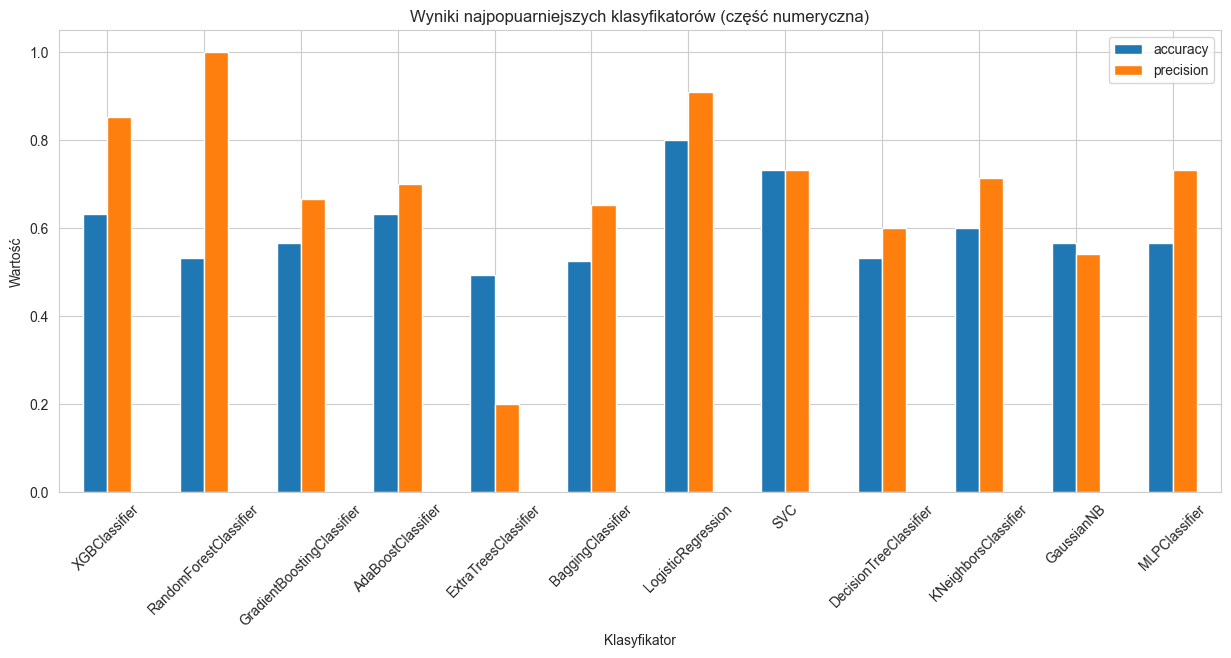

In [52]:
import matplotlib.pyplot as plt
results_df.plot(
    x='classifier',
    y=['accuracy', 'precision'],
    kind='bar',
    figsize=(15, 6),
    title='Wyniki najpopuarniejszych klasyfikatorów (część numeryczna)',
    xlabel='Klasyfikator',
    ylabel='Wartość')

plt.xticks(rotation=45)

plt.show()

### Looking for best hyperparameters for XGBClassifier

In [14]:
from sklearn.model_selection import PredefinedSplit

split_index = [-1] * len(X_train) + [0] * len(X_val)
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])
ps = PredefinedSplit(test_fold=split_index)

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score

# Initialize the XGBoost classifier
xgb = XGBClassifier()

# Define the parameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.02, 0.06],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    # 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    # 'min_child_weight': [1, 3, 5, 7],
    'reg_alpha': [0, 0.01, 0.1, 1],
    # 'reg_lambda': [0.01, 0.1, 1, 10]
}

In [27]:
random_state = 42
for i in tqdm(range(5)):
    random_search = RandomizedSearchCV(
        estimator=xgb, 
        param_distributions=param_dist,
        n_iter=200,
        scoring='precision',
        n_jobs=-1,
        cv=ps,
        random_state=random_state+i
    )
    
    random_search.fit(X_train_val, y_train_val)
    
    print(f"Best parameters found: {random_search.best_params_}")
    
    best_xgb = random_search.best_estimator_
    
    y_pred = best_xgb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    print(f"Test Accuracy: {accuracy}")
    print(f"Test Precision: {precision}")

 20%|██        | 1/5 [02:00<08:01, 120.46s/it]

Best parameters found: {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0}
Test Accuracy: 0.6333333333333333
Test Precision: 0.75


 40%|████      | 2/5 [04:09<06:15, 125.28s/it]

Best parameters found: {'subsample': 0.8, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.02, 'gamma': 0}
Test Accuracy: 0.5666666666666667
Test Precision: 0.6666666666666666


 60%|██████    | 3/5 [06:12<04:08, 124.23s/it]

Best parameters found: {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.06, 'gamma': 0.3}
Test Accuracy: 0.5
Test Precision: 0.5


 80%|████████  | 4/5 [08:07<02:00, 120.90s/it]

Best parameters found: {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06, 'gamma': 0.3}
Test Accuracy: 0.5333333333333333
Test Precision: 1.0


100%|██████████| 5/5 [10:10<00:00, 122.20s/it]

Best parameters found: {'subsample': 0.9, 'reg_alpha': 0, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1}
Test Accuracy: 0.7
Test Precision: 1.0


Best parameters found: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01}
Test Accuracy: 0.6
Test Precision: 0.7142857142857143

### Checking TabPFN: A Transformer That Solves Small Tabular Classification Problems in a Second

In [13]:
from tabpfn import TabPFNClassifier

In [33]:
X_train_small = X_train[3000:4000]
y_train_small = y_train[3000:4000]

In [34]:
tabPFNClassifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=16)

In [35]:
tabPFNClassifier.fit(X_train_small, y_train_small)

TabPFNClassifier(N_ensemble_configurations=16)

In [36]:
y_eval, p_eval = tabPFNClassifier.predict(X_test, return_winning_probability=True)

print('Accuracy', accuracy_score(y_test, y_eval))
print('Precision', precision_score(y_test, y_eval))

C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Accuracy 0.6666666666666666
Precision 0.8571428571428571


In [42]:
multiple_of_1000_of_dataset = len(X_train) // 1000

accuracy_scores = []
precision_scores = []

for i in range(0, multiple_of_1000_of_dataset):
    X_train_small = X_train[i*1000:(i+1)*1000]
    y_train_small = y_train[i*1000:(i+1)*1000]
    
    tabPFNClassifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=16)
    
    tabPFNClassifier.fit(X_train_small, y_train_small)
    
    y_eval, p_eval = tabPFNClassifier.predict(X_test, return_winning_probability=True)

    print(f"Metrics for {i*1000}:{(i+1)*1000}")
    print(f"Accuracy:", accuracy_score(y_test, y_eval))
    print(f"Precision:", precision_score(y_test, y_eval))
    
    accuracy_scores.append(accuracy_score(y_test, y_eval))
    precision_scores.append(precision_score(y_test, y_eval))

print(f"Mean accuracy: {np.mean(accuracy_scores)}")
print(f"Mean precision: {np.mean(precision_scores)}")

C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Metrics for 0:1000
Accuracy: 0.6333333333333333
Precision: 0.8333333333333334


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Metrics for 1000:2000
Accuracy: 0.5666666666666667
Precision: 0.75


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Metrics for 2000:3000
Accuracy: 0.6666666666666666
Precision: 0.8571428571428571


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Metrics for 3000:4000
Accuracy: 0.6666666666666666
Precision: 0.8571428571428571


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Metrics for 4000:5000
Accuracy: 0.6333333333333333
Precision: 0.8333333333333334


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Metrics for 5000:6000
Accuracy: 0.6
Precision: 0.8


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Metrics for 6000:7000
Accuracy: 0.5666666666666667
Precision: 0.6666666666666666
Mean accuracy: 0.619047619047619
Mean precision: 0.7996598639455783


#### Choosing best models among LogisticRegression and SVC

#### LogisticRegression

In [57]:
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm

model = LogisticRegression(random_state=random_state, penalty='l2')

param_distributions = {
    'tol': [1e-5, 1e-4, 1e-3, 1e-2],
    'C': np.logspace(-2, 3, 20),
    'max_iter': [50, 100, 200, 400, 600, 800],
    'solver': ['newton-cholesky', 'lbfgs', 'liblinear']
}

In [62]:
split_index = [-1] * len(X_train) + [0] * len(X_val)
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])
ps = PredefinedSplit(test_fold=split_index)

for i in tqdm(range(5)):
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, cv=ps, scoring='precision', n_iter=100, random_state=random_state+1, n_jobs=-1)
    
    grid_result = grid.fit(X_train_val, y_train_val)
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    preds = grid_result.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, preds)}")
    print(f"Precision: {precision_score(y_test, preds)}")

 20%|██        | 1/5 [00:16<01:07, 16.90s/it]

Best: 0.857143 using {'tol': 1e-05, 'solver': 'newton-cholesky', 'max_iter': 200, 'C': 297.63514416313194}
Accuracy: 0.8
Precision: 1.0


 40%|████      | 2/5 [00:30<00:44, 14.79s/it]

Best: 0.857143 using {'tol': 1e-05, 'solver': 'newton-cholesky', 'max_iter': 200, 'C': 297.63514416313194}
Accuracy: 0.8
Precision: 1.0


 60%|██████    | 3/5 [00:43<00:28, 14.29s/it]

Best: 0.857143 using {'tol': 1e-05, 'solver': 'newton-cholesky', 'max_iter': 200, 'C': 297.63514416313194}
Accuracy: 0.8
Precision: 1.0


 80%|████████  | 4/5 [00:57<00:14, 14.11s/it]

Best: 0.857143 using {'tol': 1e-05, 'solver': 'newton-cholesky', 'max_iter': 200, 'C': 297.63514416313194}
Accuracy: 0.8
Precision: 1.0


100%|██████████| 5/5 [01:11<00:00, 14.27s/it]

Best: 0.857143 using {'tol': 1e-05, 'solver': 'newton-cholesky', 'max_iter': 200, 'C': 297.63514416313194}
Accuracy: 0.8
Precision: 1.0


#### Results for non-flatten dataset for ExtraTreesClassifier:

Best: 0.995824 using {'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'log_loss'}
0.5

#### LogisticRegression:

Best: 0.891145 using {'tol': 0.0001, 'solver': 'liblinear', 'max_iter': 400, 'C': 29.763514416313132}
0.9

Best: 0.920516 using {'tol': 0.01, 'solver': 'newton-cholesky', 'max_iter': 500, 'C': 10000.0}
0.8

Best: 0.884323 using {'tol': 0.01, 'solver': 'liblinear', 'max_iter': 200, 'C': 1438.44988828766}
0.8666666666666667

Best: 0.900471 using {'tol': 0.0001, 'solver': 'lbfgs', 'max_iter': 200, 'C': 78.47599703514607}
0.8666666666666667

#### set scorint='precision' for LogisticRegression:

Best: 0.840436 using {'tol': 0.001, 'solver': 'newton-cholesky', 'max_iter': 100, 'C': 1000.0}
Accuracy: 0.8666666666666667
Precision: 1.0

Best: 0.808213 using {'tol': 0.0001, 'solver': 'newton-cholesky', 'max_iter': 400, 'C': 77.42636826811278}
Accuracy: 0.8666666666666667
Precision: 0.9230769230769231

Best: 0.844217 using {'tol': 1e-05, 'solver': 'newton-cholesky', 'max_iter': 100, 'C': 2335.7214690901214}
Accuracy: 0.8
Precision: 1.0

Best: 0.829150 using {'tol': 0.0001, 'max_iter': 400, 'C': 278.2559402207126}
Accuracy: 0.8666666666666667
Precision: 1.0

#### Using validation set

Best: 0.857143 using {'tol': 0.001, 'max_iter': 100, 'C': 412.46263829013566}
Accuracy: 0.8
Precision: 1.0

#### SVC

In [94]:
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.svm import SVC
import numpy as np
from tqdm import tqdm

svc = SVC(random_state=random_state)

param_distributions = {
    'tol': [1e-5, 1e-4, 1e-3, 1e-2],
    'C': np.logspace(-2, 3, 10),
    'max_iter': [100, 200, 400, 600, 800],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5, 6]
}

In [96]:
split_index = [-1] * len(X_train) + [0] * len(X_val)
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])
ps = PredefinedSplit(test_fold=split_index)
    
for i in tqdm(range(5)):
    grid = RandomizedSearchCV(estimator=svc, param_distributions=param_distributions, cv=2, scoring='precision', n_iter=100, random_state=random_state+i, n_jobs=-1)
    
    grid_result = grid.fit(X_train, y_train)

    print(f"iteration: {i+1}")
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    preds = grid_result.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, preds)}")
    print(f"Precision: {precision_score(y_test, preds)}")

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
 20%|██        | 1/5 [00:07<00:31,  8.00s/it]

iteration: 1
Best: 0.602594 using {'tol': 0.001, 'max_iter': 800, 'kernel': 'rbf', 'degree': 2, 'C': 77.42636826811278}
Accuracy: 1.0
Precision: 1.0


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
 40%|████      | 2/5 [00:12<00:17,  5.78s/it]

iteration: 2
Best: 0.589286 using {'tol': 0.0001, 'max_iter': 400, 'kernel': 'poly', 'degree': 2, 'C': 0.03593813663804628}
Accuracy: 0.5
Precision: 0.5


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
 60%|██████    | 3/5 [00:16<00:09,  4.96s/it]

iteration: 3
Best: 0.602594 using {'tol': 1e-05, 'max_iter': 800, 'kernel': 'rbf', 'degree': 3, 'C': 77.42636826811278}
Accuracy: 1.0
Precision: 1.0


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
 80%|████████  | 4/5 [00:20<00:04,  4.50s/it]

iteration: 4
Best: 0.602593 using {'tol': 1e-05, 'max_iter': 800, 'kernel': 'linear', 'degree': 6, 'C': 0.01}
Accuracy: 0.5
Precision: 0.5


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
100%|██████████| 5/5 [00:24<00:00,  4.81s/it]

iteration: 5
Best: 0.602594 using {'tol': 0.0001, 'max_iter': 800, 'kernel': 'rbf', 'degree': 5, 'C': 77.42636826811278}
Accuracy: 1.0
Precision: 1.0


#### Results for non-flatten dataset for SVC

Best: 0.589763 using {'tol': 0.01, 'shrinking': True, 'max_iter': 600, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 6, 'C': 1000.0}
Accuracy: 0.7666666666666667
Precision: 0.9

Best: 0.676811 using {'tol': 0.001, 'shrinking': True, 'max_iter': 1000, 'kernel': 'rbf', 'degree': 3, 'C': 278.2559402207126}
Accuracy: 0.8333333333333334
Precision: 0.8571428571428571

### Best models: 

In [121]:
logistic_regression_model = LogisticRegression(
    random_state=random_state, 
    max_iter=200,
    penalty='l2',
    solver='newton-cholesky',
    tol=1e-05,
    C=300.0)

svc_best_model = SVC(
    random_state=random_state,
    tol=0.001,
    shrinking=True,
    max_iter=1000,
    kernel='rbf',
    degree=3,
    C=278.25)

In [122]:
financial_dataset = pd.read_csv('bankrupt_companies_with_17variables_5years_split_version4_complete.csv')
financial_dataset = flatten_financial_dataset(financial_dataset)
financial_dataset_preprocessed = financial_dataset.drop(['cik', 'ticker', 'Fiscal Period'], axis=1)
X = financial_dataset_preprocessed.drop('label', axis=1)
y = financial_dataset_preprocessed['label']

In [123]:
financial_dataset_preprocessed.isnull().sum().sum(), (financial_dataset_preprocessed == 0).sum().sum()

(0, 6731)

In [124]:
X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test_split(X, y)

len(X_train), len(X_val), len(X_test)

(7170, 14, 30)

In [125]:
concat_train_and_val = False

if concat_train_and_val:
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])
    
    scaler = preprocessing.StandardScaler().fit(X_train_val)
    
    X_train_val = scaler.transform(X_train_val)
    X_test = scaler.transform(X_test)
    
else:
    scaler = preprocessing.StandardScaler().fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

In [126]:
logistic_regression_model.fit(X_train, y_train)

preds = logistic_regression_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")

Accuracy: 0.8
Precision: 1.0


In [105]:
svc_best_model.fit(X_train, y_train)

preds = svc_best_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")

Accuracy: 0.7333333333333333
Precision: 0.7058823529411765


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Running best model on the whole new dataset (https://github.com/sowide/bankruptcy_dataset)

In [362]:
american_bankruptcy_dataset = pd.read_csv('american_bankruptcy_dataset.csv')
print(american_bankruptcy_dataset.shape)

(78682, 23)


In [363]:
american_bankruptcy_dataset_grouped = american_bankruptcy_dataset.groupby('company_name')
american_bankruptcy_dataset_filtered = american_bankruptcy_dataset_grouped.filter(lambda x: len(x) >= 5)
print(american_bankruptcy_dataset_filtered.shape)

(71123, 23)


In [364]:
american_bankruptcy_dataset_grouped = american_bankruptcy_dataset_filtered.groupby('company_name')
american_bankruptcy_dataset_5years = pd.DataFrame()

for group in american_bankruptcy_dataset_grouped:
    if len(group[1]) >= 5:
        last_5_years = group[1].tail(5)
        american_bankruptcy_dataset_5years = pd.concat([american_bankruptcy_dataset_5years, last_5_years])
        
print(american_bankruptcy_dataset_5years.shape)

(29365, 23)


In [365]:
american_bankruptcy_dataset_5years.head()

,company_name,fyear,status_label,X1,X2,X3,X4,X5,X6,X7,...,X11,X12,X13,X14,X15,X16,X17,X18,Division,MajorGroup
14,C_1,2013.0,alive,1116.9,2199.5,1581.4,564.3,113.4,142.6,256.0,...,72.9,616.7,297.9,2035.0,9.613080e+05,1198.8,2035.0,1779.0,D,37
15,C_1,2014.0,alive,954.1,1515.0,1342.7,85.0,92.3,-8.6,83.7,...,10.2,603.9,231.1,1594.3,1.046395e+03,669.9,1594.3,1510.6,D,37
16,C_1,2015.0,alive,873.1,1442.1,1354.9,136.1,70.8,66.1,136.9,...,47.7,637.2,242.7,1662.6,8.425112e+02,576.3,1662.6,1525.7,D,37
17,C_1,2016.0,alive,888.5,1504.1,1422.7,155.3,71.0,77.2,148.2,...,56.5,688.0,251.4,1767.6,1.200329e+03,589.9,1767.6,1619.4,D,37
18,C_1,2017.0,alive,942.7,1524.7,1413.2,177.2,40.5,86.0,126.5,...,15.6,701.2,203.0,1748.3,1.551458e+06,588.4,1748.3,1621.8,D,37


In [258]:
# dropping X9 (Net sales) column because there are no equivalent columns in the created financial dataset
american_bankruptcy_dataset_5years.drop(['X9'], axis=1, inplace=True)

american_bankruptcy_dataset_5years.columns = [
    'company_name',
    'fyear',
    'label',
    'Current assets',
    'Cost of goods sold',
    'Depreciation and amortization',
    'EBITDA', 
    'Inventory',
    'Net Income',
    'Total Receivables',
    'Market value',
    'Total assets',
    'Total Long term debt',
    'EBIT',
    'Gross Profit',
    'Total Current Liabilities',
    'Retained Earnings',
    'Total Revenue',
    'Total Liabilities',
    'Total Operating Expenses',
    'Division',
    'MajorGroup'
]

# reordering columns so Division and MajorGroup are after label
american_bankruptcy_dataset_5years = american_bankruptcy_dataset_5years[['company_name', 'fyear', 'label', 'Division', 'MajorGroup', 
                                                                         'Cost of goods sold', 'Depreciation and amortization', 'EBIT',  
                                                                         'EBITDA', 'Gross Profit', 'Total Long term debt', 'Market value', 'Net Income', 
                                                                         'Retained Earnings', 'Total Revenue', 'Total assets', 'Current assets',
                                                                         'Total Current Liabilities', 'Inventory', 'Total Liabilities', 
                                                                         'Total Operating Expenses', 'Total Receivables', 
                                                                         
                                                                         
                                                                         ]]

# renaming columns names with features to much with the financial dataset
american_bankruptcy_dataset_5years.columns = [
    'company_name',
    'fyear',
    'label',
    'Division',
    'MajorGroup',
    'Cost of Goods Sold',
    'Depreciation, Depletion and Amortization',
    'EBIT',
    'EBITDA',
    'Gross Profit',
    'Long-Term Debt',
    'Market Cap',
    'Net Income',
    'Retained Earnings',
    'Revenue',
    'Total Assets',
    'Total Current Assets',
    'Total Current Liabilities',
    'Total Inventories',
    'Total Liabilities',
    'Total Operating Expense',
    'Total Receivables'
]

american_bankruptcy_dataset_5years['label'] = american_bankruptcy_dataset_5years['label'].apply(lambda x: True if x == 'failed' else False)
american_bankruptcy_dataset_5years.to_csv('sowide_american_bankruptcy_dataset_5years_named_features_withoutX9.csv', index=False)

american_bankruptcy_dataset_5years.head(10)

,company_name,fyear,label,Division,MajorGroup,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
14,C_1,2013.0,False,D,37,2199.5,1581.4,616.7,564.3,297.900,...,142.600,9.613080e+05,1198.80,402.100,1116.900,2035.0,113.4,2035.0,1779.0,256.000
15,C_1,2014.0,False,D,37,1515.0,1342.7,603.9,85.0,231.100,...,-8.600,1.046395e+03,669.90,412.000,954.100,1594.3,92.3,1594.3,1510.6,83.700
16,C_1,2015.0,False,D,37,1442.1,1354.9,637.2,136.1,242.700,...,66.100,8.425112e+02,576.30,329.000,873.100,1662.6,70.8,1662.6,1525.7,136.900
17,C_1,2016.0,False,D,37,1504.1,1422.7,688.0,155.3,251.400,...,77.200,1.200329e+03,589.90,335.100,888.500,1767.6,71.0,1767.6,1619.4,148.200
18,C_1,2017.0,False,D,37,1524.7,1413.2,701.2,177.2,203.000,...,86.000,1.551458e+06,588.40,333.300,942.700,1748.3,40.5,1748.3,1621.8,126.500
125,C_10,2014.0,False,E,49,14313532.0,2263032.0,1857924.0,3031215.0,395179.000,...,811242.000,7.553105e+06,9794.43,1559.143,973435.000,3491632.0,417358.0,3491632.0,2263032.0,1228.600
126,C_10,2015.0,False,E,49,15028258.0,2146419.0,2048055.0,3462391.0,367806.000,...,854602.000,7.155990e+03,10308801.00,1442317.000,890.516,3495443.0,494422.0,3495443.0,2146419.0,1349024.000
127,C_10,2016.0,False,E,49,16004253.0,2156869.0,2211725.0,4021785.0,355403.000,...,855.984,8.687626e+03,11068341.00,1292946.000,822.219,3498682.0,485829.0,3498682.0,2156869.0,1341813.000
128,C_10,2017.0,False,E,49,17019082.0,2096751.0,2397509.0,4789713.0,415068.000,...,934427.000,9.519035e+03,11883352.00,1197852.000,1016288.000,3565296.0,534118.0,3565296.0,2096751.0,1468545.000
129,C_10,2018.0,False,E,49,17664202.0,2335206.0,2593475.0,4638232.0,400.988,...,773687.000,9.551090e+03,12315497.00,1648964.000,924991.000,3691247.0,582354.0,3691247.0,2335206.0,1356.041


In [259]:
american_bankruptcy_dataset_5years['label'].value_counts(normalize=True)

label
False    0.914013
True     0.085987
Name: proportion, dtype: float64

In [108]:
american_bankruptcy_dataset_5years = pd.read_csv('sowide_american_bankruptcy_dataset_5years_named_features_withoutX9.csv')
american_bankruptcy_dataset_5years.head()

,company_name,fyear,label,Division,MajorGroup,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,C_1,2013.0,False,D,37,2199.5,1581.4,616.7,564.3,297.9,...,142.6,9.613080e+05,1198.8,402.1,1116.9,2035.0,113.4,2035.0,1779.0,256.0
1,C_1,2014.0,False,D,37,1515.0,1342.7,603.9,85.0,231.1,...,-8.6,1.046395e+03,669.9,412.0,954.1,1594.3,92.3,1594.3,1510.6,83.7
2,C_1,2015.0,False,D,37,1442.1,1354.9,637.2,136.1,242.7,...,66.1,8.425112e+02,576.3,329.0,873.1,1662.6,70.8,1662.6,1525.7,136.9
3,C_1,2016.0,False,D,37,1504.1,1422.7,688.0,155.3,251.4,...,77.2,1.200329e+03,589.9,335.1,888.5,1767.6,71.0,1767.6,1619.4,148.2
4,C_1,2017.0,False,D,37,1524.7,1413.2,701.2,177.2,203.0,...,86.0,1.551458e+06,588.4,333.3,942.7,1748.3,40.5,1748.3,1621.8,126.5


In [109]:
def flatten_american_bankruptcy_dataset(financial_dataset):
    object_length_in_rows = 5
    metadata_columns_length = 5
    
    per_object_columns = list(financial_dataset.columns[:metadata_columns_length].values)
    
    value_columns = financial_dataset.columns[metadata_columns_length:]
    new_columns = per_object_columns + [f'{col}_{i+1}' for i in range(object_length_in_rows) for col in value_columns]
    
    dfs = []
    
    for i in range(0, len(financial_dataset), object_length_in_rows):
        group = financial_dataset.iloc[i:i + object_length_in_rows]
        if len(group) < object_length_in_rows:
            break

        company_name = group['company_name'].iloc[0]
        fiscal_periods = ';'.join(group['fyear'].astype(str).values)
        label = group['label'].iloc[0]
        division = group['Division'].iloc[0]
        major_group = group['MajorGroup'].iloc[0]

        values = group.drop(columns=per_object_columns).values.flatten()
        
        dfs.append([company_name, fiscal_periods, label, division, major_group] + values.tolist())
    
    final_flatten_df = pd.DataFrame(dfs, columns=new_columns)
    final_flatten_df = final_flatten_df.reset_index(drop=True)
    return final_flatten_df

In [110]:
# check how many zeros and Nan are in the dataset
american_bankruptcy_dataset_5years.isnull().sum().sum(), (american_bankruptcy_dataset_5years == 0).sum().sum()

(0, 36054)

In [111]:
36054-31385

4669

In [112]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

american_bankruptcy_dataset_5years_zeros_filled = pd.DataFrame()
# 31385
for group in tqdm(american_bankruptcy_dataset_5years.groupby('company_name')):
    tmp_df = group[1].replace(to_replace=0, method='bfill').replace(to_replace=0, method='ffill')
    american_bankruptcy_dataset_5years_zeros_filled = pd.concat([american_bankruptcy_dataset_5years_zeros_filled, tmp_df])

100%|██████████| 5873/5873 [00:23<00:00, 248.30it/s]


In [113]:
american_bankruptcy_dataset_5years_zeros_filled.isnull().sum().sum(), (american_bankruptcy_dataset_5years_zeros_filled == 0).sum().sum()

(0, 31385)

In [114]:
american_bankruptcy_dataset_5years_zeros_filled['label'].value_counts()

label
False    26840
True      2525
Name: count, dtype: int64

In [115]:
american_bankruptcy_dataset_5years_zeros_filled['label'].value_counts(normalize=True)

label
False    0.914013
True     0.085987
Name: proportion, dtype: float64

In [117]:
len(american_bankruptcy_dataset_5years_zeros_filled)/5

5873.0

In [118]:
american_bankruptcy_dataset_5years_flatten = flatten_american_bankruptcy_dataset(american_bankruptcy_dataset_5years_zeros_filled)
american_bankruptcy_dataset_5years_preprocessed = american_bankruptcy_dataset_5years_flatten.drop(['company_name', 'fyear', 'Division', 'MajorGroup'], axis=1)

In [119]:
X_american_bankruptcy_dataset = american_bankruptcy_dataset_5years_preprocessed.drop('label', axis=1)
y_american_bankruptcy_dataset  = american_bankruptcy_dataset_5years_preprocessed['label']

scaler = preprocessing.StandardScaler().fit(X_american_bankruptcy_dataset)
X_scaled = scaler.transform(X_american_bankruptcy_dataset)

len(X_american_bankruptcy_dataset), len(y_american_bankruptcy_dataset)

(5873, 5873)

In [147]:
preds = logistic_regression_model.predict(X_american_bankruptcy_dataset)
print(f"Accuracy: {accuracy_score(y_american_bankruptcy_dataset, preds)}")
print(f"Precision: {precision_score(y_american_bankruptcy_dataset, preds)}")

Accuracy: 0.6022475736420909
Precision: 0.11614255765199162


### Check only on the balanced dataset

In [131]:
X_negative = X_american_bankruptcy_dataset[y_american_bankruptcy_dataset == False]
y_negative = y_american_bankruptcy_dataset[y_american_bankruptcy_dataset == False]

X_positive = X_american_bankruptcy_dataset[y_american_bankruptcy_dataset == True]
y_positive = y_american_bankruptcy_dataset[y_american_bankruptcy_dataset == True]

X_negative = X_negative.sample(n=len(X_positive), random_state=random_state)
y_negative = y_negative.sample(n=len(X_positive), random_state=random_state)

X_combined = pd.concat([X_positive, X_negative])
y_combined = pd.concat([y_positive, y_negative])

len(X_positive), len(y_positive), len(X_negative), len(y_negative)

(505, 505, 505, 505)

In [148]:
preds = logistic_regression_model.predict(X_combined)
print(f"Accuracy: {accuracy_score(y_combined, preds)}")
print(f"Precision: {precision_score(y_combined, preds)}")

Accuracy: 0.5831683168316831
Precision: 0.5893617021276596


#### Results for american dataset:

Accuracy: 0.42475247524752474
Precision: 0.4291044776119403

## Dataset comparison

In [134]:
df1 = pd.read_csv('bankrupt_companies_with_17variables_5years_split_version4_complete.csv')
df2 = pd.read_csv('sowide_american_bankruptcy_dataset_5years_named_features_withoutX9.csv')

df1.drop(['cik', 'ticker', 'Fiscal Period', 'label', 'subset'], axis=1, inplace=True)
df2.drop(['company_name', 'fyear', 'Division', 'MajorGroup', 'label'], axis=1, inplace=True)

In [135]:
df1.describe()

,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,Long-Term Debt,Market Cap,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
count,36070.000000,36070.000000,36070.000000,36070.000000,36070.000000,36070.000000,36070.000000,36070.000000,36070.000000,36070.000000,36070.000000,36070.000000,36070.000000,36070.000000,36070.000000,36070.000000,36070.000000
mean,1934.947645,159.123548,238.338251,413.881706,926.406197,1610.033816,5989.537362,112.663139,720.306467,2424.338431,6123.653281,1225.193032,944.684192,307.752604,4670.662164,692.662734,473.959917
std,9821.346437,788.010657,1984.669021,2481.130740,4012.584621,9241.430375,23794.312435,1577.485425,9089.127282,12266.487814,29979.611252,5434.181010,4096.337123,1311.744289,24923.514324,2749.307308,2690.754193
min,-1647.000000,-59.000000,-27725.000000,-27317.000000,-5685.000000,0.000000,0.000000,-27590.000000,-85041.000000,-1992.140000,0.000000,0.000000,0.000000,0.000000,-4733.000000,-3518.000000,0.000000
25%,147.000000,9.400000,-16.000000,4.000000,92.100000,97.000000,299.000000,-37.000000,-163.000000,212.000000,386.000000,131.000000,73.000000,24.000000,226.000000,89.000000,28.000000
50%,372.000000,26.000000,31.000000,58.000000,202.000000,309.000000,1041.000000,6.640000,15.000000,505.000000,789.000000,281.310000,151.000000,70.000000,552.000000,199.000000,71.000000
75%,932.000000,96.000000,139.300000,230.000000,542.775000,916.975000,3568.750000,58.000000,181.000000,1137.750000,2699.900000,642.000000,424.300000,206.000000,1885.000000,440.000000,204.100000
max,420315.000000,46009.000000,111852.000000,123136.000000,152836.000000,429944.000000,995107.000000,94680.000000,444626.000000,559151.000000,992968.000000,184406.000000,125481.000000,81715.000000,902703.000000,116288.000000,128387.000000


In [136]:
df2.describe()

,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,Long-Term Debt,Market Cap,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
count,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04,2.936500e+04
mean,6.243817e+05,3.833786e+05,2.361547e+04,1.764228e+05,6.900689e+04,1.254670e+04,1.745298e+05,4.144138e+04,4.968603e+05,3.856770e+05,1.289232e+05,2.150358e+05,5.592116e+05,2.594476e+04,5.592116e+05,4.750706e+05,6.586093e+04
std,2.057566e+06,2.415372e+06,8.377113e+05,8.014096e+05,2.845943e+05,1.895519e+05,5.936148e+05,2.225606e+05,5.364679e+06,1.454710e+06,5.471249e+05,7.071624e+05,2.742011e+06,1.005920e+05,2.742011e+06,2.256353e+06,2.662746e+05
min,7.000000e-03,-3.143700e+04,-1.900383e+07,-2.300000e+01,0.000000e+00,-7.058978e+06,-4.367571e+06,-5.043795e+06,1.000000e-04,7.000000e-03,7.000000e-03,-2.498000e+03,-1.977000e+03,0.000000e+00,-1.977000e+03,-3.143700e+04,-4.512135e+06
25%,3.480900e+03,1.355600e+03,-5.355800e+04,0.000000e+00,2.125000e+02,-3.991000e+03,4.117600e+02,-1.392000e+03,4.155930e+01,2.224707e+03,1.062400e+03,1.292000e+03,1.941200e+03,7.300000e+01,1.941200e+03,3.113000e+03,-3.267000e+01
50%,4.448300e+04,2.078200e+04,-8.027000e+01,5.752870e+02,4.119000e+03,5.547000e+00,1.165600e+04,1.624000e+02,3.446880e+02,1.963200e+04,1.169300e+04,2.196500e+04,3.424400e+04,1.162400e+03,3.424400e+04,3.929200e+04,8.870000e+02
75%,3.458750e+05,1.730550e+05,1.414400e+04,1.986100e+04,3.916900e+04,5.894000e+03,1.132980e+05,1.541500e+04,3.157765e+03,1.662730e+05,7.300300e+04,1.549930e+05,3.132310e+05,1.280800e+04,3.132310e+05,2.746480e+05,2.973200e+04
max,4.827507e+07,1.632456e+08,3.095666e+07,2.068708e+07,1.154206e+07,7.521731e+06,1.724914e+07,6.946234e+06,3.748024e+08,3.921136e+07,2.786969e+07,2.430330e+07,1.679396e+08,4.165616e+06,1.679396e+08,1.657008e+08,8.845605e+06


In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

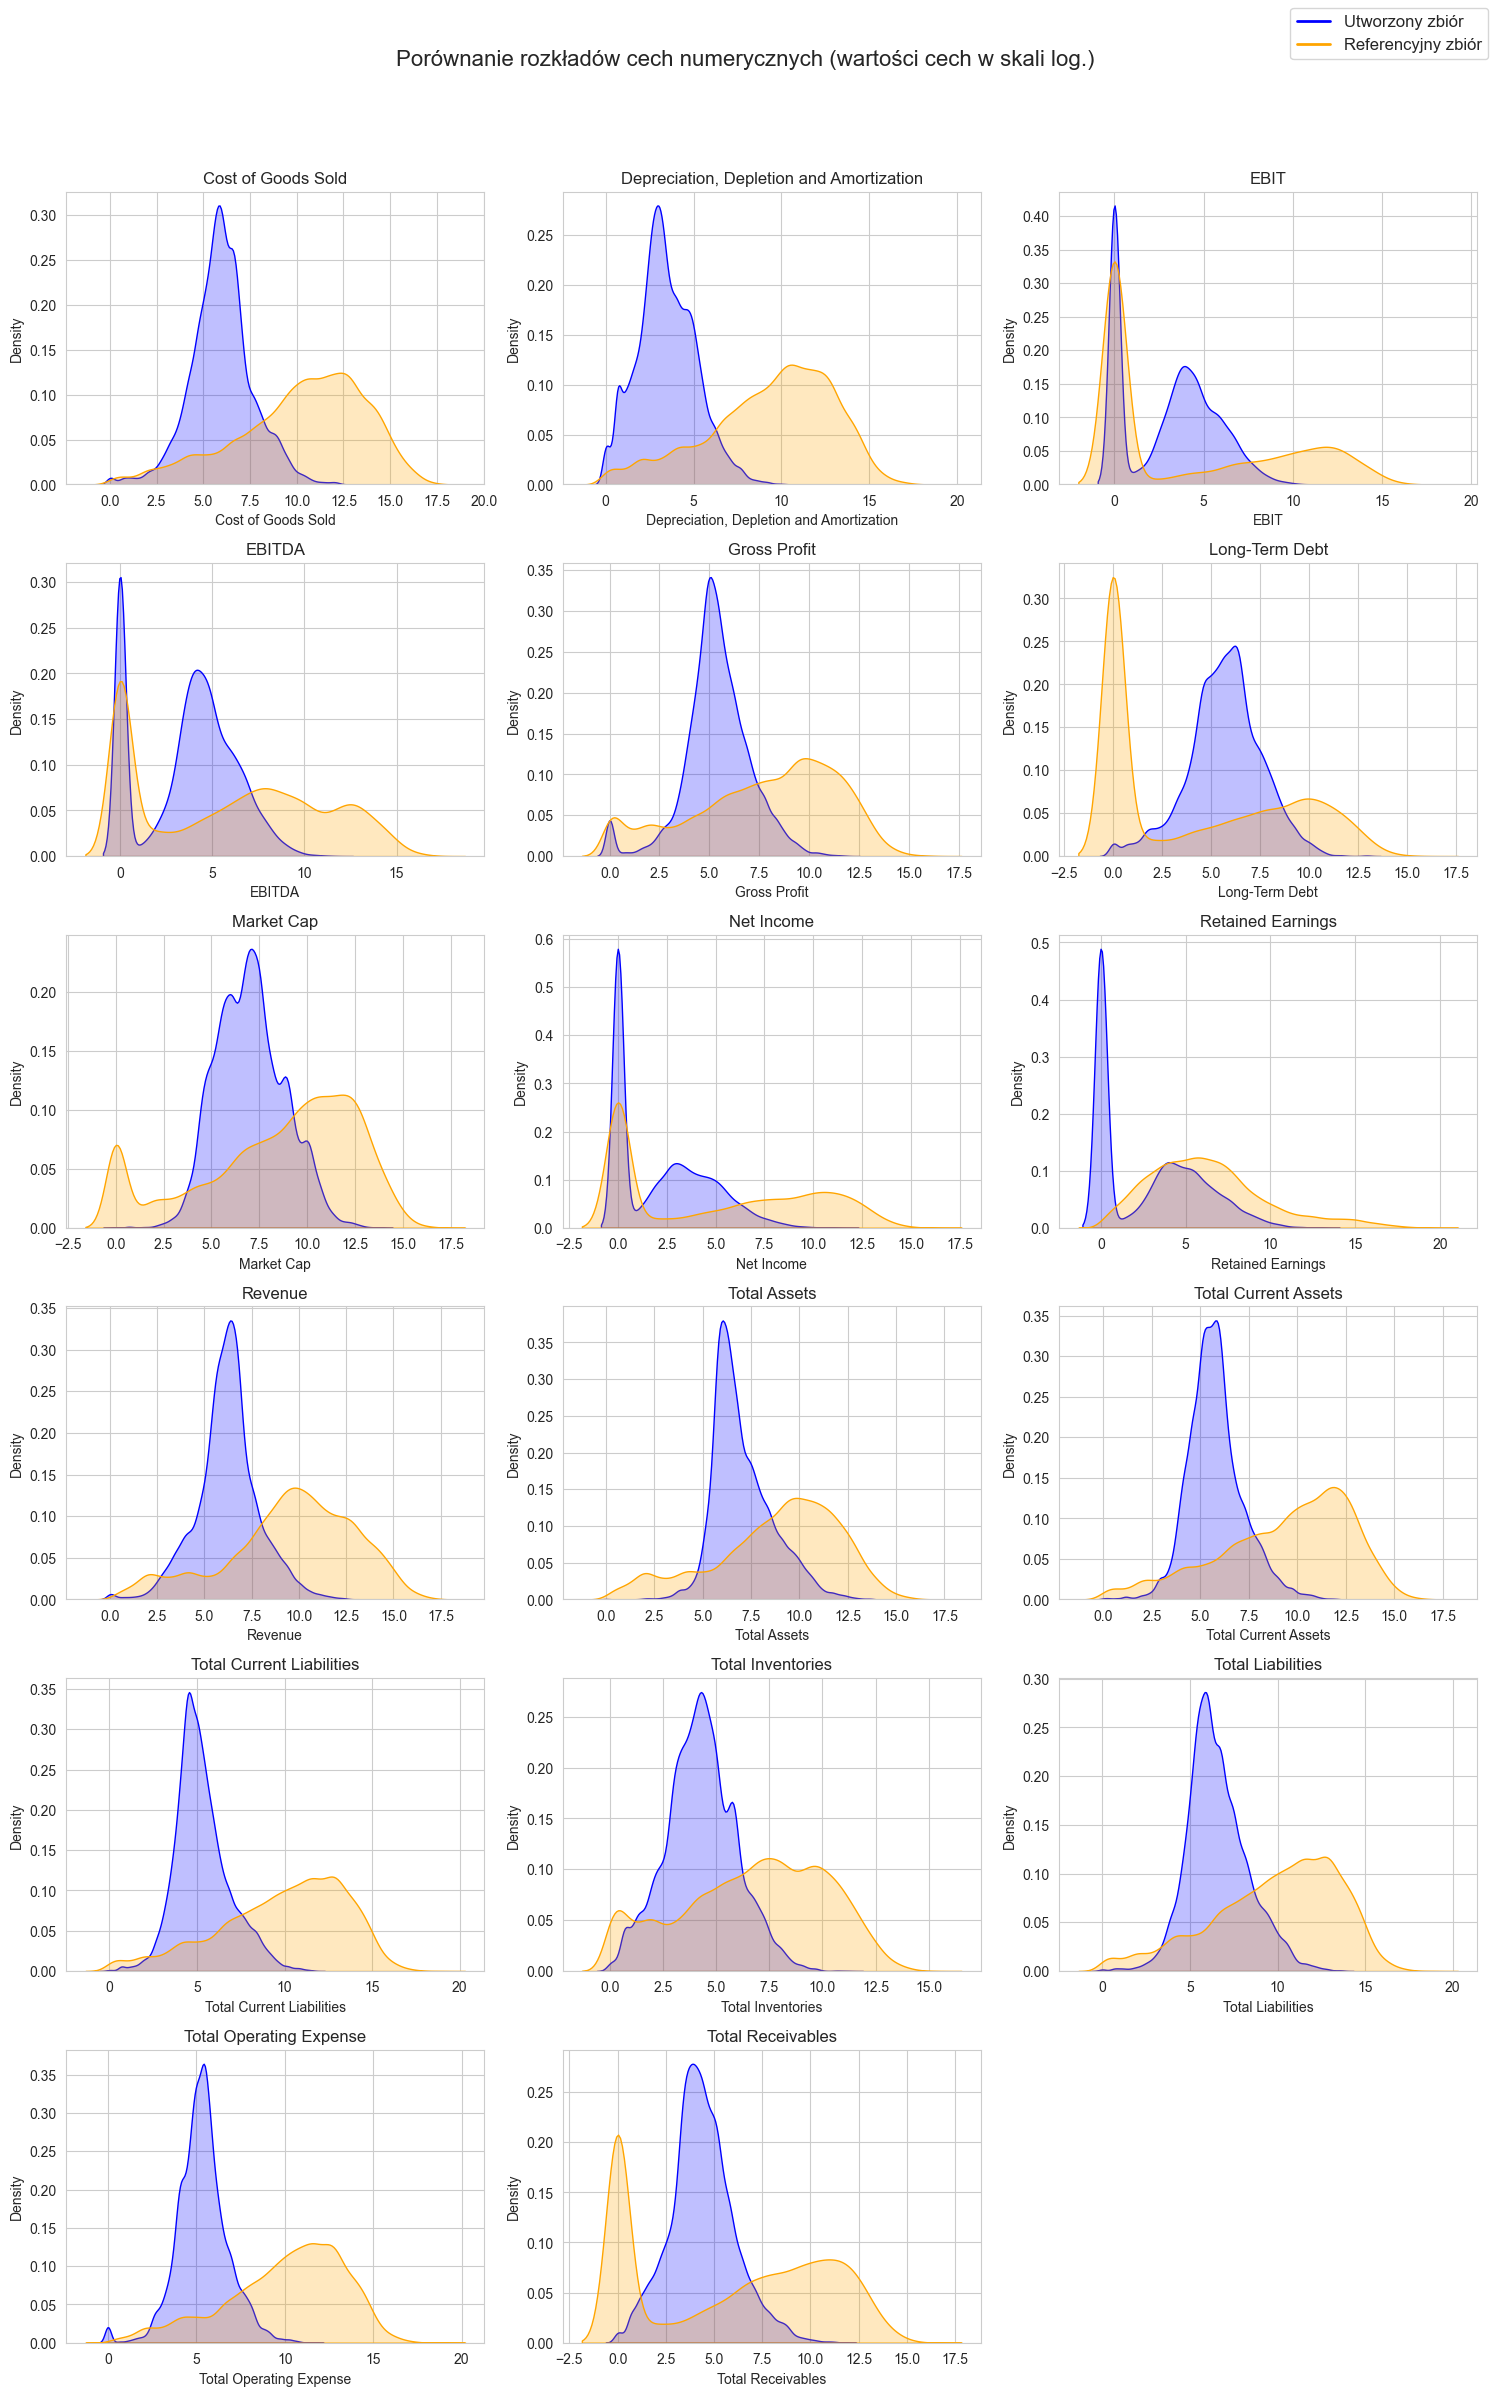

In [145]:
numeric_columns = df1.select_dtypes(include=['float64', 'int64']).columns

# Determine the number of rows and columns for subplots
n_cols = 3  # You can adjust the number of columns
n_rows = math.ceil(len(numeric_columns) / n_cols)

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
fig.suptitle('Porównanie rozkładów cech numerycznych (wartości cech w skali log.)', fontsize=16)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through each column and plot on the respective subplot
for idx, column in enumerate(numeric_columns):
    # Log transform both datasets, avoiding log(0) by adding a small constant
    df1_log = np.log1p(df1[column].clip(lower=1e-5))  # log1p(x) = log(1 + x), handles small values
    df2_log = np.log1p(df2[column].clip(lower=1e-5))
    
    sns.kdeplot(df1_log, shade=True, ax=axes[idx], color='blue')
    sns.kdeplot(df2_log, shade=True, ax=axes[idx], color='orange')
    axes[idx].set_title(f'{column}')

# Remove any unused axes if the number of features is less than n_cols * n_rows
for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

# Create a single legend for the entire figure
handles = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Utworzony zbiór'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Referencyjny zbiór')
]

fig.legend(handles=handles, loc='upper right', ncol=1, fontsize=12)

# Adjust layout to avoid overlap
plt.tight_layout(rect=(0, 0, 1, 0.95))  # Adjust rect to fit the suptitle and legend
plt.show()